In [1]:
from __future__ import division, print_function, absolute_import

#A Practical Guide to the Machine Learning Workflow:
Separating Stars and Galaxies from SDSS 
========

#####Version 0.1

***
By AA Miller 2017 Jan 22

We will now follow the steps from the machine learning workflow lecture to develop an end-to-end machine learning model using actual astronomical data. As a reminder the workflow is as follows:

1. Data Preparation
2. Model Building
3. Model Evaluation
4. Model Optimization
5. Model Predictions

Some of these steps will be streamlined to allow us to fully build a model within the alloted time.

*Science background*: Many (nearly all?) of the science applications for LSST data will rely on the accurate separation of stars and galaxies in the LSST imaging data. As an example, imagine measuring galaxy clustering without knowing which sources are galaxies and which are stars. 

During this exercise, we will utilize supervised machine-learning methods to separate extended (galaxies) and point sources (stars, QSOs) in imaging data. These methods are highly flexible, and as a result can classify sources at higher fidelity than methods that simply make cuts in a low-dimensional space.

In [9]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

##Problem 1) Obtain and Examine Training Data

As a reminder, for supervised-learning problems we use a training set, sources with known labels, i.e. they have been confirmed as normal stars, QSOs, or galaxies, to build a model to classify new observations where we do not know the source label.

The training set for this exercise uses Sloan Digital Sky Survey (SDSS) data. For features, we will start with each $r$-band magnitude measurement made by SDSS. This yields 8 features (twice that of the Iris data set, but significantly fewer than the 454 properties measured for each source in SDSS).

Step 1 in the ML workflow is data preparation - we must curate the training set. As a reminder: 

**A machine-learning model is only as good as its training set.** 

This point cannot be emphasized enough. Machine-learning models are data-driven, they do not capture any physical theory, and thus it is essential that the training set satisfy several criteria. 

Two of the most important criteria for a good training set are: 

+ the training set should be unbiased [this is actually really hard to achieve in astronomy since most surveys are magnitude limited]
+ the training set should be representative of the (unobserved or field) population of sources [a training set with no stars will yield a model incapable of discovering point sources]

So, **step 1** (this is a must), we are going to examine the training set to see if anything suspicious is going on. We will use [`astroquery`](https://astroquery.readthedocs.io/en/latest/) to directly access the SDSS database, and store the results in an [`astropy` Table](http://astropy.readthedocs.org/en/latest/table/). 

**Note** The SDSS API for `astroquery` is not standard for the package, which leads to a warning. This is not, however, a problem for our purposes.

In [10]:
from astroquery.sdss import SDSS  # enables direct queries to the SDSS database

While it is possible to look up each of the names of the $r$-band magnitudes in the [SDSS `PhotoObjAll` schema](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx?cmd=description+PhotoObjAll+U#&&history=description+PhotoObjAll+U), the schema list is long, and thus difficult to parse by eye. Fortunately, we can identify the desired columns using the database itself:

    select COLUMN_NAME
    from INFORMATION_SCHEMA.Columns
    where table_name = 'PhotoObjAll' AND 
    COLUMN_NAME like '%Mag/_r' escape '/'

which returns the following list of columns: `psfMag_r, fiberMag_r, fiber2Mag_r, petroMag_r, deVMag_r, expMag_r, modelMag_r, cModelMag_r`. 

We now select these magnitude measurements for 10000 stars and galaxies from SDSS. Additionally, we join these photometric measurements with the `SpecObjAll` table to obtain their spectroscopic classifications, which will serve as labels for the machine-learning model.

**Note** - the SDSS database contains duplicate observations, flagged observations, and non-detections, which we condition the query to exclude (as explained further below). We also exclude quasars, as the precise photometric classification of these objects is ambiguous: low-$z$ AGN have resolvable host galaxies, while high-$z$ QSOs are point-sources. Query conditions:

* `p.mode = 1` select only the primary photometric detection of a source
* `s.sciencePrimary = 1` select only the primary spectroscopic detection of a source (together with above, prevents duplicates)
* `p.clean = 1` the SDSS [`clean`](http://www.sdss.org/dr12/algorithms/photo_flags_recommend/) flag excludes flagged observations and sources with non-detections
* `s.class != 'QSO'` removes potentially ambiguous QSOs from the training set

In [8]:
sdss_query = """SELECT TOP 10000
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
             ORDER BY p.objid ASC
               """
sdss_set = SDSS.query_sql(sdss_query)
sdss_set

psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class
float64,float64,float64,float64,float64,float64,float64,float64,str6
18.50319,18.65275,19.33509,17.54539,17.31526,17.58132,17.58132,17.48715,GALAXY
19.02659,19.32441,19.80892,19.05827,19.03468,19.03111,19.03111,19.03111,STAR
19.8809,19.77895,20.46623,19.3534,19.1864,19.35493,19.35493,19.24559,GALAXY
22.03563,22.06141,22.68416,21.51795,21.03554,21.31751,21.31751,21.31751,GALAXY
21.56726,21.57312,22.22178,20.4583,19.93309,20.39825,20.39819,20.20402,GALAXY
18.66813,18.75309,19.36792,17.83372,17.69468,17.89914,17.6947,17.75269,GALAXY
20.19068,20.33947,20.93226,19.77666,19.63458,19.74873,19.74872,19.74873,GALAXY
19.41619,19.38348,20.15486,17.67687,17.16815,17.63962,17.63962,17.63962,GALAXY
18.88878,18.91179,19.57415,17.3317,17.02896,17.43539,17.02898,17.06256,GALAXY


To reiterate a point from above: data-driven models are only as good as the training set. Now that we have a potential training set, it is essential to inspect the data for any peculiarities.

**Problem 1a**

Can you easily identify any important properties of the data from the above table?

If not - is there a better way to examine the data?

*Hint* - emphasis on easy.

**Solution 1a**

This is the first instance where domain knowledge really helps us to tackle this problem. In this case the domain knowledge is the following: PSF measurements of galaxy brightness are terrible. Thus, `psfmag_r` is very different from the other mag measurements for galaxies, but similar for stars. Of course - this is readily identifiable, even to those without domain knowledge, if we visualize the data.

**Problem 1b**

Visualize the 8 dimensional feature set [this is intentionally open-ended...] 

Does this visualization reveal anything that is not obvious from the table?

Can you identify any biases in the training set? 

**Remember - always worry about the data**

*Hint* `astropy Tables` can be converted to `pandas DataFrames` with the `.to_pandas()` operator.

In [ ]:
# complete

:0: FutureWarning: IPython widgets are experimental and may change in the future.


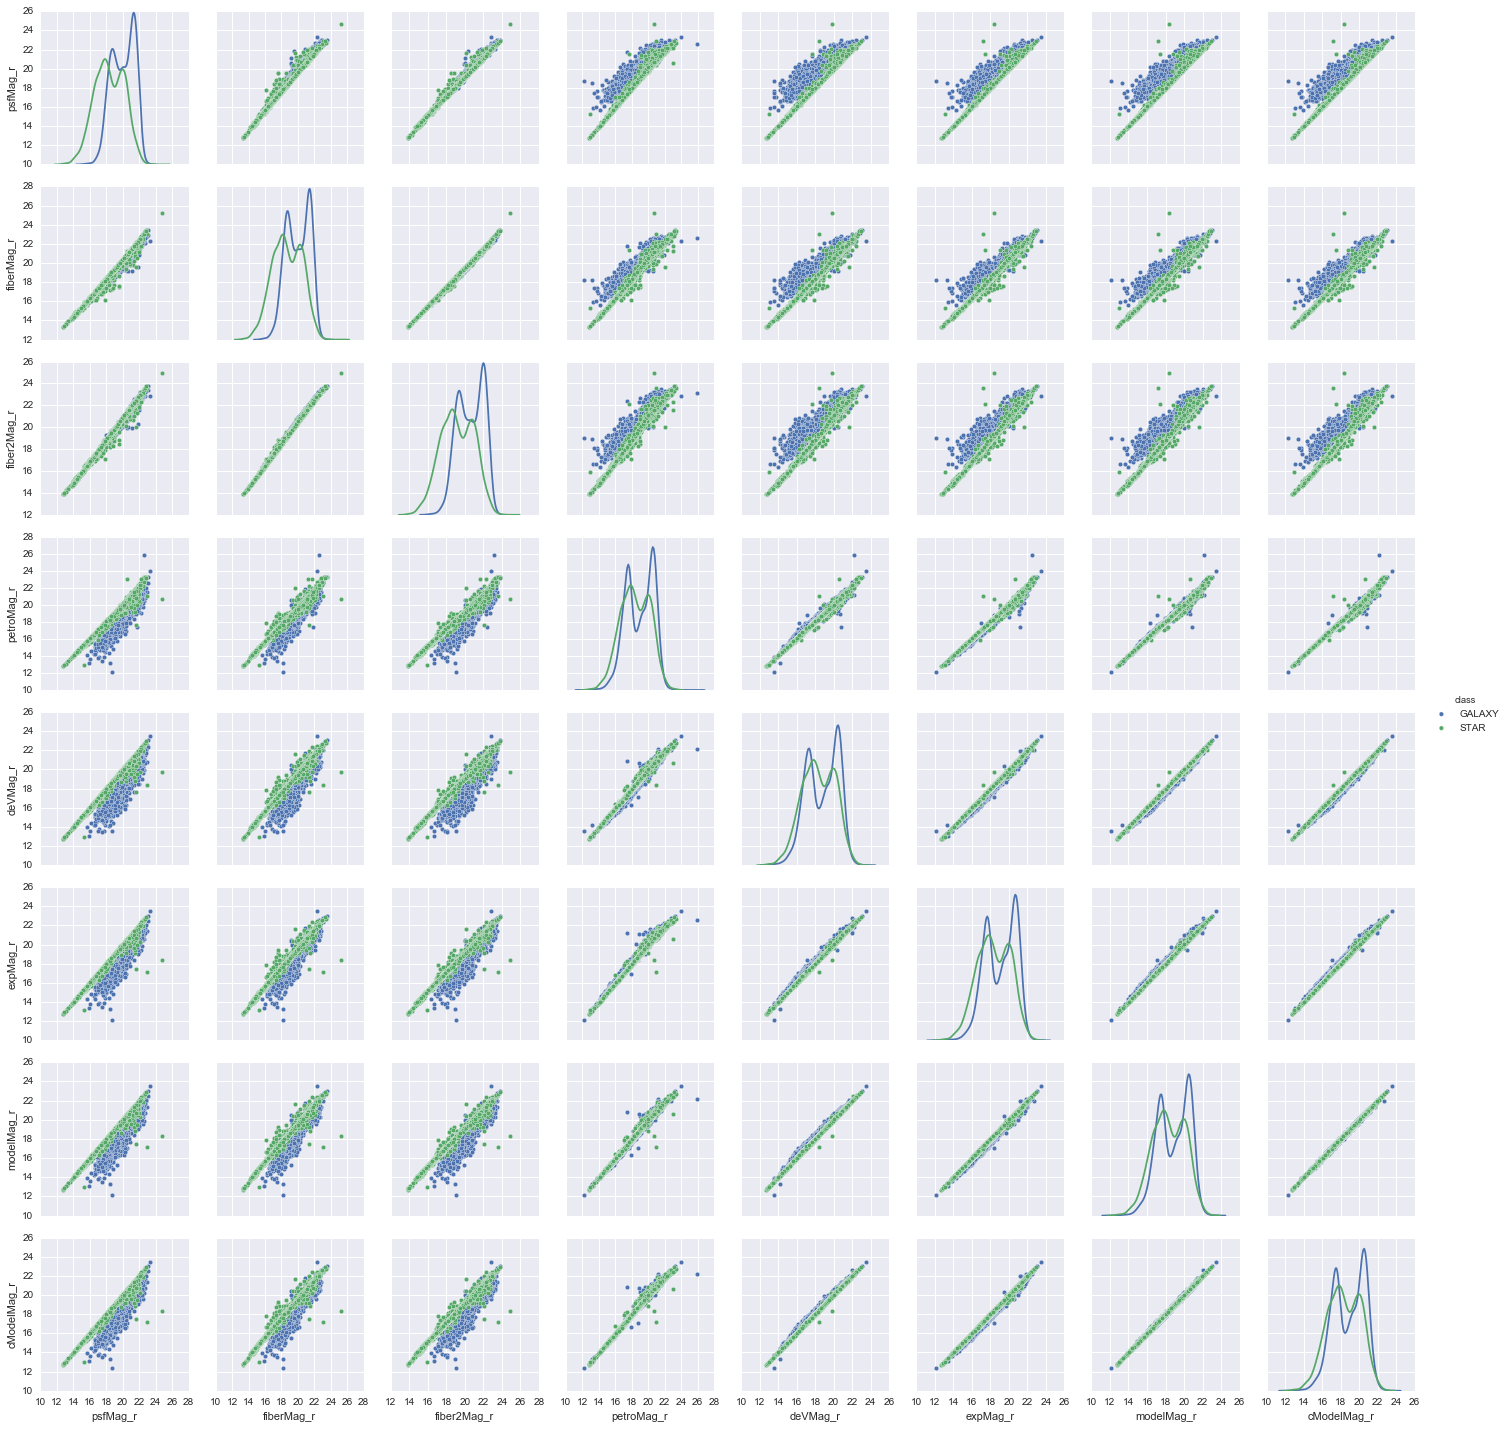

In [11]:
import seaborn as sns
sns.pairplot(sdss_set.to_pandas(), hue = 'class', diag_kind = 'kde')

**Solution 1b**

The visualization confirms our domain knowledge assertion: galaxy PSF measurements differ significantly from the other magnitude measurements. 

The visualization also reveals the magnitude distribution of the training set, as well as a potential bias: the dip in the distribution at $r' \approx 19$ mag. There is no reason nature should produce fewer $r' \approx 19$ mag stars than $r' \approx 18$ mag stars, and, indeed, this is a bias due to the SDSS spectroscopic targeting algorithm. We will proceed, but we should be weary of this moving forward.

Finally, to finish off our preparation of the data - we need to create an independent test that will be used to evalute the accuracy/generalization properies of the model after everything has been tuned. Often, independent test sets are generated by witholding a fraction of the training set. No hard and fast rules apply for the fraction to be withheld, though typical choices vary between $\sim{0.2}-0.5$. For this problem we will adopt 0.3.

[`sklearn.model_selection`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) has a handy function [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), which will simplify this process.

**Problem 1c** Split the 10k spectroscopic sources 70-30 into training and test sets. Save the results in arrays called: `train_X, train_y, test_X, test_y`, respectively. Use `rs` for the `random_state` in `train_test_split`.

*Hint - recall that `sklearn` utilizes X, a 2D `np.array()`, and y as the features and labels arrays, respecitively.*

In [ ]:
from sklearn.model_selection import train_test_split
rs = 2  # we are in second biggest metropolitan area in the US

# complete

X = np.array( # complete
y = np.array( # complete

train_X, test_X, train_y, test_y = train_test_split( X, y,  # complete

In [70]:
from sklearn.model_selection import train_test_split
rs = 2  # we are in second biggest metropolitan area in the US

feats = list(sdss_set.columns)
feats.remove('class')

X = np.array(sdss_set[feats].to_pandas())
y = np.array(sdss_set['class'])

train_X, test_X, train_y, test_y = train_test_split( X, y, test_size = 0.3, random_state = rs)

##Problem 2) An Aside on the Importance of Feature Engineering

It has been said that all machine learning is an exercise in feature engineering. 

Feature engineering - the process of creating new features, combining features, removing features, collecting new data to supplement existing features, etc. is essential in the machine learning workflow. As part of the data preparation stage, it is useful to apply domain knowledge to engineer features prior to model construction. [Though it is important to know that feature engineering may be needed at any point in the ML workflow if the model does not provide desired results.]

Due to a peculiarity of our SDSS training set, we need to briefly craft a separate problem to demonstrate the importance of feature engineering. 

For this aside, we will train the model on bright ($r' < 18.5$ mag) sources and test the model on faint ($r' > 19.5$ mag) sources. As you might guess the model will not perform well. Following some clever feature engineering, we will be able to improve this. 

*aside-to-the-aside*

This exact situation happens in astronomy all the time, and it is known as sample selection bias. In brief, any time a larger aperture telescope is built, or instrumentation is greatly improved, a large swath of sources that were previously undetectable can now be observed. These fainter sources, however, may contain entirely different populations than their brighter counterparts, and thus any models trained on the bright sources will be biased when making predictions on the faint sources.

We train and test the model with 10000 sources using an identical query to the one employed above, with the added condition restricting the training set to bright sources and the test set to faint sources. 

In [6]:
bright_query = """SELECT TOP 10000
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
             AND p.cModelMag_r < 18.5
             ORDER BY p.objid ASC
               """
bright_set = SDSS.query_sql(bright_query)
bright_set

psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class
float64,float64,float64,float64,float64,float64,float64,float64,str6
18.50319,18.65275,19.33509,17.54539,17.31526,17.58132,17.58132,17.48715,GALAXY
18.66813,18.75309,19.36792,17.83372,17.69468,17.89914,17.6947,17.75269,GALAXY
19.41619,19.38348,20.15486,17.67687,17.16815,17.63962,17.63962,17.63962,GALAXY
18.88878,18.91179,19.57415,17.3317,17.02896,17.43539,17.02898,17.06256,GALAXY
17.73892,17.8784,18.4601,16.81384,16.80538,17.07542,16.80538,16.80538,GALAXY
18.63271,18.7262,19.34857,17.52713,17.39202,17.70089,17.39205,17.42522,GALAXY
15.59505,15.90016,16.37692,15.63732,15.59175,15.59168,15.59175,15.59175,STAR
16.86786,17.18411,17.66562,16.92053,16.87619,16.87632,16.87632,16.87632,STAR
15.52249,15.84067,16.32653,15.56999,15.52024,15.52037,15.52037,15.52037,STAR


In [7]:
faint_query = """SELECT TOP 10000
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
             AND p.cModelMag_r > 19.5
             ORDER BY p.objid ASC
               """
faint_set = SDSS.query_sql(faint_query)
faint_set

psfMag_r,fiberMag_r,fiber2Mag_r,petroMag_r,deVMag_r,expMag_r,modelMag_r,cModelMag_r,class
float64,float64,float64,float64,float64,float64,float64,float64,str6
22.03563,22.06141,22.68416,21.51795,21.03554,21.31751,21.31751,21.31751,GALAXY
21.56726,21.57312,22.22178,20.4583,19.93309,20.39825,20.39819,20.20402,GALAXY
20.19068,20.33947,20.93226,19.77666,19.63458,19.74873,19.74872,19.74873,GALAXY
20.88323,20.69596,21.34235,19.8385,19.54691,19.83536,19.83536,19.80019,GALAXY
21.68742,21.65661,22.21959,21.38967,21.41017,21.48285,21.48281,21.42866,GALAXY
21.31183,21.22101,21.83354,20.37388,20.28695,20.53661,20.28695,20.28695,GALAXY
23.03102,23.48423,23.80237,23.2707,23.02958,23.00128,23.00127,23.00128,GALAXY
21.03335,20.94627,21.52036,20.12525,20.11247,20.44011,20.11246,20.11247,GALAXY
21.65844,21.62826,22.19918,21.023,20.94729,21.17266,20.94729,20.94729,GALAXY


**Problem 2a** 

Train a $k$ Nearest Neighbors model with $k = 11$ neighbors on the 10k source training set. Note - for this particular problem, the number of neighbors does not matter much.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

feats = # complete


bright_X = # complete
bright_y = # complete

KNNclf = # complete

In [26]:
from sklearn.neighbors import KNeighborsClassifier

feats = list(bright_set.columns)
feats.remove('class')

bright_X = np.array(bright_set[feats].to_pandas())
bright_y = np.array(bright_set['class'])

KNNclf = KNeighborsClassifier(n_neighbors = 11)
KNNclf.fit(bright_X, bright_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

**Problem 2b** 

Evaluate the accuracy of the model when applied to the sources in the faint test set. 

Does the model perform well?

*Hint - you may find [`sklearn.metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) useful for this exercise.*

In [ ]:
from sklearn.metrics import accuracy_score

faint_X = # complete
faint_y = # complete

faint_preds = # complete

print("The raw features produce a KNN model with accuracy ~{:.4f}".format( # complete

In [27]:
from sklearn.metrics import accuracy_score

faint_X = np.array(faint_set[feats].to_pandas())
faint_y = np.array(faint_set['class'])

faint_preds = KNNclf.predict(faint_X)

print("The raw features produce a KNN model with accuracy ~{:.4f}".format(accuracy_score(faint_y, faint_preds)))

The raw features produce a KNN model with accuracy ~0.6760


**Solution 2b** 

Based on the pair plots generated above - stars and galaxies appear highly distinct based on their SDSS $r'$-band measurements, thus, this model likely exhibits poor performance. [we will see if we can confirm this]

Leveraging the same domain knowledge discussed above, namely that galaxies cannot be modeled with a PSF, we can "normalize" the magnitude measurements by taking their difference relative to `psfMag_r`. This normalization has the added advantage of removing any knowledge of the apparent brightness of the sources, which should help when comparing independent bright and faint sets.

**Problem 2c** 

Normalize the feature vector relative to `psfMag_r`, and refit the $k$NN model to the 7 newly engineered features.

Does the accuracy improve when predicting the class of sources in the faint test set? 

*Hint - be sure you apply the eaxct same normalization to both the training and test set* 

In [ ]:
bright_Xnorm = # complete

KNNclf = # complete

faint_predsNorm = # complete

print("The normalized features produce an accuracy ~{:.4f}".format( # complete

In [30]:
bright_Xnorm = bright_X[:,0][:,np.newaxis] - bright_X[:,1:]
faint_Xnorm = faint_X[:,0][:,np.newaxis] - faint_X[:,1:]


KNNclf = KNeighborsClassifier(n_neighbors = 11)
KNNclf.fit(bright_Xnorm, bright_y)

faint_predsNorm = KNNclf.predict(faint_Xnorm)

print("The normalized features produce an accuracy ~{:.4f}".format(accuracy_score(faint_y, faint_predsNorm)))

The normalized features produce an accuracy ~0.9099


**Solution 2c** 

Wow! Normalizing the features produces a huge ($\sim{35}\%$) increase in accuracy. Clearly, we should be using normalized magnitude features moving forward.

In addition to demonstrating the importance of feature engineering, this exercise teaches another important lesson: contextual features can be dangerous. 

Contextual astronomical features can provide very strong priors: stars are more likely close to the galactic plane, supernovae occur next to/on top of galaxies, bluer stars have have lower metallicity, etc. Thus, including contextual information may improve overall model performance.

However, all astronomical training sets are heavily biased. Thus, the strong priors associated with contextual features can lead to severely biased model predictions.

Generally, I (AAM) remove all contextual features from my ML models for this reason. If you are building ML models, consider contextual information as it may help overall performance, but... be weary.

### Worry about the data

##Problem 3) Model Building

After the data have been properly curated, the next important choice in the ML workflow is the selection of ML algorithm. With experience, it is possible to develop intuition for the best ML algorithm given a specific problem.

Short of that? Try three (or four, or five) different models and choose whichever works the best. 

For the star-galaxy problem, we will use the Random Forest (RF) algorithm [(Breiman 2001)](http://link.springer.com/article/10.1023/A:1010933404324) as implemented by `scikit-learn`.

[`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is part of the [`sklearn.ensemble`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) module.

RF has a number of nice properties for working with astronomical data:

+ relative insensitivity to noisy or useless features
+ invariant response to highly non-gaussian feature distributions
+ fast, flexible and scales well to large data sets

which is why we will adopt it here.

**Problem 3a** 

Build a RF model using the normalized features from the training set.

Include 25 trees in the forest using the `n_estimators` paramater in `RandomForestClassifier`.

In [ ]:
import # complete
rs = 626 # aread code for Pasadena

train_Xnorm = # complete

RFclf = # complete

In [50]:
from sklearn.ensemble import RandomForestClassifier
rs = 626 # aread code for Pasadena

train_Xnorm = train_X[:,0][:,np.newaxis] - train_X[:,1:]

RFclf = RandomForestClassifier(n_estimators = 25, random_state = rs)
RFclf.fit(train_Xnorm, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=626,
            verbose=0, warm_start=False)

`scikit-learn` really makes it easy to build ML models.

Another nice property of RF is that it naturally provides an estimate of the most important features in the model. 

[Once again - feature engineering comes into play, as it may be necessary to remove correlated features or unimportant features during the model construction in order to reduce run time or allow the model to fit in the available memory.]

In this case we don't need to remove any features [RF is relatively immune to correlated or unimportant features], but for completeness we measure the importance of each feature in the model. 

RF feature importance is measured by randomly shuffling the values of a particular feature, and measuring the decrease in the model's overall accuracy. The relative feature importances can be accessed using the `.feature_importances_` attribute associated with the `RandomForestClassifer()` class. The higher the value, the more important feature. 

**Problem 3b** 

Calculate the relative importance of each feature. 

Which feature is most important? Can you make sense of the feature ordering? 

*Hint - do not dwell too long on the final ordering of the features.*

In [ ]:
 # complete
    

print("The relative importance of the features is: \n{:s}".format(  # complete

In [51]:
print(RFclf.feature_importances_)   # print the importances

indicies = np.argsort(RFclf.feature_importances_)[::-1]   # sort the features most imp. --> least imp.

# recall that all features are normalized relative to psfMag_r
featStr = ", \n".join(['psfMag_r - {:s}'.format(x) for x in list(np.array(feats)[1:][indicies])])

print("The relative importance of the features is: \n{:s}".format(featStr))

[ 0.04507396  0.01803911  0.15869275  0.26786948  0.12175759  0.19368635
  0.19488078]
The relative importance of the features is: 
psfMag_r - deVMag_r, 
psfMag_r - cModelMag_r, 
psfMag_r - modelMag_r, 
psfMag_r - petroMag_r, 
psfMag_r - expMag_r, 
psfMag_r - fiberMag_r, 
psfMag_r - fiber2Mag_r


**Solution 3b** 

`psfMag_r - deVMag_r` is the most important feature. This makes sense based on the separation of stars and galaxies in the `psfMag_r`-`deVMag_r` plane (see the visualization results above). 

*Note* - the precise ordering of the features can change due to their strong correlation with each other, though the `fiberMag` features are always the least important.

##Problem 4) Model Evaluation

To evaluate the performance of the model we establish a baseline (or figure of merit) that we would like to exceed. This in essence is the essential "engineering" step of machine learning [and why I (AAM) often caution against ML for scientific measurements and advocate for engineering-like problems instead]. 

If the model does not improve upon the baseline (or reach the desired figure of merit) then one must iterate on previous steps (feature engineering, algorithm selection, etc) to accomplish the desired goal.

The SDSS photometric pipeline uses a simple parametric model to classify sources as either stars or galaxies. If we are going to the trouble of building a complex ML model, then it stands to reason that its performance should exceed that of the simple model. Thus, we adopt the SDSS photometric classifier as our baseline.

Tthe SDSS photometric classifier uses a [single hard cut](http://www.sdss.org/dr12/algorithms/classify/#photo_class) to separate stars and galaxies in imaging data:

$$\mathtt{psfMag} - \mathtt{cmodelMag} > 0.145.$$

Sources that satisfy this criteria are considered galaxies. 

**Problem 4a** 

Determine the baseline for the ML model by measuring the accuracy of the SDSS photometric classifier on the training set. 

*Hint - you may need to play around with array values to get `accuracy_score` to work.*

In [ ]:
# complete

print("The SDSS phot model produces an accuracy ~{:.4f}".format( # complete

In [52]:
phot_y = train_Xnorm[:,6] > 0.145
phot_class = np.empty(len(phot_y), dtype = '|S6')
phot_class[phot_y] = 'GALAXY'
phot_class[phot_y == False] = 'STAR'

print("The SDSS phot model produces an accuracy ~{:.4f}".format(accuracy_score(train_y, phot_class)))

The SDSS phot model produces an accuracy ~0.9641


The simple SDSS model sets a high standard! A $\sim{96}\%$ accuracy following a single hard cut is a phenomenal  performance.

**Problem 4b** Using 10-fold cross validation, estimate the accuracy of the RF model. 

In [ ]:
from sklearn.model_selection import # complete

RFpreds = # complete

print("The CV accuracy for the training set is {:.4f}".format( # complete

In [53]:
from sklearn.model_selection import cross_val_predict

RFpreds = cross_val_predict(RFclf, train_Xnorm, train_y, cv = 10)

print("The CV accuracy for the training set is {:.4f}".format(accuracy_score(train_y, RFpreds)))

The CV accuracy for the training set is 0.9686


Phew! Our hard work to build a machine learning model has been rewarded, by creating an improved model: $\sim{96.9}\%$ accuracy vs. $\sim{96.4}\%$.

[But - was our effort worth only a $0.5\%$ improvement in the model?]

##Problem 5) Model Optimization

While the "off-the-shelf" model provides an improvement over the SDSS photometric classifier, we can further refine and improve the performance of the machine learning model by adjusting the model tuning parameters. A process known as model optimization.

All machine-learning models have tuning parameters. In brief, these parameters capture the smoothness of the model in the multidimentional-feature space. Whether the model is smooth or coarse is application dependent -- be weary of over-fitting or under-fitting the data. Generally speaking, RF (and most tree-based methods) have 3 flavors of tuning parameter:

1. $N_\mathrm{tree}$ - the number of trees in the forest `n_estimators` (default: 10) in `sklearn`
2. $m_\mathrm{try}$ - the number of (random) features to explore as splitting criteria at each node `max_features` (default: `sqrt(n_features)`) in `sklearn`
3. Pruning criteria - defined stopping criteria for ending continued growth of the tree, there are [many choices](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for this in `sklearn` (My preference is `min_samples_leaf` (default: 1) which sets the minimum number of sources allowed in a terminal node, or leaf, of the tree)

Just as we previously evaluated the model using CV, we must optimize the tuning paramters via CV. Until we "finalize" the model by fixing all the input parameters, we cannot evalute the accuracy of the model with the test set as that would be "snooping."

On Tuesday we were introduced to [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which is an excellent tool for optimizing model parameters. 

Before we get to that, let's try to develop some intuition for how the tuning parameters affect the final model predictions.

**Problem 5a** 

Determine the 5-fold CV accuracy for models with $N_\mathrm{tree}$ = 1, 10, 100. 

How do you expect changing the number of trees to affect the results?

In [ ]:
rs = 1936 # year JPL was founded

CVpreds1 = # complete

# complete

# complete

print("The CV accuracy for 1, 10, 100 trees is {:.4f}, {:.4f}, {:.4f}".format( # complete

In [57]:
rs = 1936 # year JPL was founded

CVpreds1 = cross_val_predict(RandomForestClassifier(n_estimators = 1, random_state=rs), 
                           train_Xnorm, train_y, cv = 5)

CVpreds10 = cross_val_predict(RandomForestClassifier(n_estimators = 10, random_state=rs), 
                            train_Xnorm, train_y, cv = 5)

CVpreds100 = cross_val_predict(RandomForestClassifier(n_estimators = 100, random_state=rs), 
                             train_Xnorm, train_y, cv = 5)

print("The CV accuracy for 1, 10, 100 trees is {:.4f}, {:.4f}, {:.4f}".format(accuracy_score(train_y, CVpreds1), 
                                                                              accuracy_score(train_y, CVpreds10), 
                                                                              accuracy_score(train_y, CVpreds100)))

The CV accuracy for 1, 10, 100 trees is 0.9473, 0.9670, 0.9691


**Solution 5a** 

Using a single tree will produce high variance results, as the features selected at the top of the tree greatly influence the final classifications. Thus, we expect it to have the lowest accuracy. 

While (in this case) the affect is small, it is clear that $N_\mathrm{tree}$ affects the model output. 

Now we will optimize the model over all tuning parameters. How does one actually determine the optimal set of tuning parameters? 

*Brute force.*

This data set and the number of tuning parameters is small, so brute force is appropriate (alternatives exist when this isn't the case). We can optimize the model via a grid search that performs CV at each point in the 3D grid. The final model will adopt the point with the highest accuracy.

It is important to remember two general rules of thumb: (i) if the model is optimized at the edge of the grid, refit a new grid centered on that point, and (ii) the results should be stable in the vicinity of the grid maximum. If this is not the case the model is likely overfit. 

**Problem 5b** 

Use [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to perform a **3-fold** CV grid search to optimize the RF star-galaxy model. Remember the rules of thumb. 

What are the optimal tuning parameters for the model?

*Hint 1 - think about the computational runtime based on the number of points in the grid. Do not start with a very dense or large grid.*

*Hint 2 - if the runtime is long, don't repeat the grid search even if the optimal model is on an edge of the grid*

In [ ]:
rs = 64 # average temperature in Los Angeles

from sklearn.model_selection import GridSearchCV

grid_results = # complete


print("The optimal parameters are:")
for key, item in grid_results.best_params_.items(): # warning - slightly different meanings in Py2 & Py3
    print("{}: {}".format(key, item))

In [59]:
rs = 64 # average temperature in Los Angeles

from sklearn.model_selection import GridSearchCV

grid_results = GridSearchCV(RandomForestClassifier(random_state = rs), 
                            {'n_estimators': [30, 100, 300], 'max_features': [1, 3, 7], 'min_samples_leaf': [1,10]},
                            cv = 3)
grid_results.fit(train_Xnorm, train_y)

print("The optimal parameters are:")
for key, item in grid_results.best_params_.items(): # warning - slightly different meanings in Py2 & Py3
    print("{}: {}".format(key, item))

The optimal parameters are:
max_features: 3
n_estimators: 30
min_samples_leaf: 10


Now that the model is fully optimized - we are ready for the moment of truth!

**Problem 5c**

Using the optimized model parameters, train a RF model and estimate the model's generalization error using the test set.

How does this compare to the baseline model?

In [ ]:
RFopt_clf = # complete

test_preds = # complete

print('The optimized model produces a generalization error of {:.4f}'.format( # complete

In [72]:
RFopt_clf = RandomForestClassifier(n_estimators=30, max_features=3, min_samples_leaf=10)
RFopt_clf.fit(train_Xnorm, train_y)

test_Xnorm = test_X[:,0][:,np.newaxis] - test_X[:,1:]
test_preds = RFopt_clf.predict(test_Xnorm)

print('The optimized model produces a generalization error of {:.4f}'.format(1 - accuracy_score(test_y, test_preds)))

The optimized model produces a generalization error of 0.0303


**Solution 5c**

The optimized model provides a $\sim{0.6}\%$ improvement over the baseline model.

We will now examine the performance of the model using some alternative metrics. 

*Note* - if these metrics are essential for judging the model performance, then they should be incorporated to the workflow in the evaluation stage, prior to examination of the test set. 

**Problem 5d**

Calculate the confusion matrix for the model, as determined by the test set.

Is there symmetry to the misclassifications?

In [ ]:
from sklearn.metrics import # complete

# complete

In [74]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, test_preds)
print(cm)

[[1348   46]
 [  45 1561]]


**Solution 5d**

Adopting galaxies as the positive class, the TPR = 96.7%, while the TNR = 97.1%. Thus, yes, these is ~symmetry to the classifications.

**Problem 5e**

Calculate and plot the ROC curves for both stars and galaxies.

*Hint - you'll need probabilities in order to calculate the ROC curve.*

In [ ]:
from sklearn.metrics import roc_curve

test_preds_proba = # complete
# complete

fpr, tpr, thresholds = roc_curve( # complete
plt.plot( # complete

plt.legend()

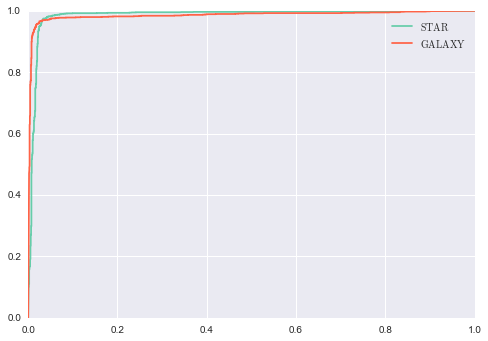

In [88]:
from sklearn.metrics import roc_curve, roc_auc_score

test_preds_proba = RFopt_clf.predict_proba(test_Xnorm)
test_y_stars = np.zeros(len(test_y), dtype = int)
test_y_stars[np.where(test_y == "STAR")] = 1
test_y_galaxies = test_y_stars*-1. + 1

fpr, tpr, thresholds = roc_curve(test_y_stars, test_preds_proba[:,1])
plt.plot(fpr, tpr, label = r'$\mathrm{STAR}$', color = "MediumAquaMarine")

fpr, tpr, thresholds = roc_curve(test_y_galaxies, test_preds_proba[:,0])
plt.plot(fpr, tpr, label = r'$\mathrm{GALAXY}$', color = "Tomato")

plt.legend()

**Problem 5f**

Suppose you want a model that only misclassifies 1% of stars as galaxies. 

What classification threshold should be adopted for this model?

What fraction of galaxies does this model miss?

Can you think of a reason to adopt such a threshold?

In [ ]:
# complete

In [92]:
fpr01_idx = (np.abs(fpr-0.01)).argmin()

tpr01 = tpr[fpr01_idx]
threshold01 = thresholds[fpr01_idx]

print("To achieve FPR = 0.01, a decision threshold = {:.4f} must be adopted".format(threshold01))
print("This threshold will miss {:.4f} of galaxies".format(1 - tpr01))

To achieve FPR = 0.01, a decision threshold = 0.8844 must be adopted
This threshold will miss 0.0789 of galaxies


**Solution 5f**

When building galaxy 2-point correlation functions it is very important to avoid including stars in the statistics as they will bias the final measurement. 

Finally - always remember: 

### **worry about the data**

##Challenge Problem) Taking the Plunge
###Applying the model to field data

QSOs are unresolved sources that look like stars in optical imaging data. We will now download photometric measurements for 10k QSOs from SDSS and see how accurate the RF model performs for these sources. 

In [95]:
QSO_query = """SELECT TOP 10000 
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'QSO'
             ORDER BY s.specobjid ASC
               """
QSO_set = SDSS.query_sql(QSO_query)

**Challenge 1** 

Calculate the accuracy with which the model classifies QSOs based on the 10k QSOs selected with the above command. How does that accuracy compare to that estimated by the test set?

In [103]:
qso_X = np.array(QSO_set[feats].to_pandas())
qso_y = np.empty(len(QSO_set),dtype='|S4')    # we are defining QSOs as stars for this exercise
qso_y[0:-1] = 'STAR' 
qso_Xnorm = qso_X[:,0][:,np.newaxis] - qso_X[:,1:]

qso_preds = RFclf.predict(qso_Xnorm)

print("The RF model correctly classifies ~{:.4f} of the QSOs".format(accuracy_score(qso_y, qso_preds)))

The RF model correctly classifies ~0.8664 of the QSOs


**Challenge 2** 

Can you think of any reasons why the performance would be so much worse for the QSOs than it is for the stars? 

Can you obtain a ~.97 accuracy when classifying QSOs?

In [106]:
# As discussed above, low-z AGN have resolved host galaxies which will confuse the classifier, 
# this can be resolved by only selecting high-z QSOs (z > 1.5)

QSO_query = """SELECT TOP 10000 
             p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
             p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
             s.class
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'QSO'
             AND s.z > 1.5
             ORDER BY s.specobjid ASC
               """
QSO_set = SDSS.query_sql(QSO_query)

qso_X = np.array(QSO_set[feats].to_pandas())
qso_y = np.empty(len(QSO_set),dtype='|S4')    # we are defining QSOs as stars for this exercise
qso_y[0:-1] = 'STAR' 
qso_Xnorm = qso_X[:,0][:,np.newaxis] - qso_X[:,1:]

qso_preds = RFclf.predict(qso_Xnorm)

print("The RF model correctly classifies ~{:.4f} of the QSOs".format(accuracy_score(qso_y, qso_preds)))

The RF model correctly classifies ~0.9886 of the QSOs


**Challenge 3** 

Perform an actual test of the model using "field" sources. The SDSS photometric classifier is nearly perfect for sources brighter than $r = 21$ mag. Download a random sample of $r < 21$ mag photometric sources, and classify them using the optimized RF model. Adopting the photometric classifications as ground truth, what is the accuracy of the RF model?

*Hint - you'll need to look up the parameter describing photometric classification in SDSS*

In [ ]:
# complete